<a href="https://colab.research.google.com/github/tylerwalkerbrown/stock_analysis/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install streamlit
!pip install matplotlib
!pip install requests
!pip install beautifulsoup4
!pip install tensorflow
!pip install pandas
!pip install scikit-learn
!pip install tweepy
!pip install yfinance
!pip install newsapi-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=f6b8827abc96b67e283f8c1a9cccbe275d7e7752be7a8192145fea8300402395
  Stored in directory:

In [ ]:
import os
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tweepy
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from newsapi.newsapi_client import NewsApiClient
import datetime

# Get the current date
current_date = datetime.date.today()
# Get the current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)

# List files in the directory
file_list = os.listdir(current_dir)
print("Files in the directory:")
for file in file_list:
    print(file)
os.chdir('/content/drive/MyDrive/stocks_app')

company = "Apple stock"
ticker_chosen = "AAPL"
sentiment = 'neutral'
start_date = "2022-04-01" 
end_date = current_date

Current directory: /content
Files in the directory:
.config
drive
sample_data


Function to get summary of the news articles for the stock you decide to choose. It first obtains a json that contains the link to top articles related to the ticker then grabs the summary text in that link using BS4.

In [ ]:
def news_summary(link):
  # Define the URL
  url = str(link)

  # Send a GET request to the URL
  response = requests.get(url)

  # Parse the HTML content
  soup = BeautifulSoup(response.content, "html.parser")

  # Find the article content
  article_content = soup.find("div", class_="caas-body")

  # Extract the article title
  article_title_element = article_content.find("h1")
  article_title = article_title_element.text.strip() if article_title_element else "Title Not Found"

  # Extract the article summary
  article_summary_element = article_content.find("p")
  article_summary = article_summary_element.text.strip() if article_summary_element else "Summary Not Found"

  # Print the article title and summary
  return article_summary



def model(text_data):
  model_save_path = 'trained_model.h5'
  model = load_model(model_save_path)

  # New data
  new_data = [ str(text_data)  ]

  # Tokenize and pad the sequences of the new data
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(new_data)
  new_sequences = tokenizer.texts_to_sequences(new_data)
  max_sequence_length = 71  # Set the desired maximum sequence length
  new_padded = pad_sequences(new_sequences, maxlen=max_sequence_length)

  # Make predictions on the new data
  predictions = model.predict(new_padded)

  # Example: Decode numerical labels back to original string labels
  label_encoder = LabelEncoder()  # Instantiate the label encoder
  label_encoder.fit(["neutral", "negative", "positive"])  # Set the label classes as "neutral", "negative", and "positive"
  predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

  # Create a DataFrame to store the new data and predictions
  df_new = pd.DataFrame({'Text': new_data, 'Predicted Label': predicted_labels})

  # Print the DataFrame
  return df_new['Predicted Label']


#Yahoo finance articles
def define_news(ticker_chosen):
    from datetime import date
    current_date = date.today()
    ticker = yf.Ticker(ticker_chosen)
    news = {'date': [] , 'sentiment':[], 'summary': []}

    for i in range(0, 8):
        try:
            news['summary'].append(news_summary(ticker.news[i]['link']))
            text = str(news_summary(ticker.news[i]['link']))
            news['sentiment'].append(model(text)[0])
            news['date'].append(current_date)

        except:
            pass

    df_news = pd.DataFrame(news)
    return df_news

def news_articles():
  # Create a NewsApiClient object and set your API key
  api_key = '8ef3967d57a34f0a8617a22f6e269407'
  newsapi = NewsApiClient(api_key=api_key)

  # Define the parameters for the request
  parameters = {
      'q': '{}'.format(company),       # Specify the keyword 'apple'
      'language': 'en'
  }

  response = newsapi.get_everything(**parameters)

  articles = {'date': [],
              'sentiment': [],
              'summary': [] }
  articles = response['articles']

  df = pd.DataFrame(articles)[['publishedAt','description' ]]

  article_data = {'date':[],
                  'sentiment': [],
                  'summary' : []}

  for i in range(0,len(articles)):
    article_data['date'].append(df['publishedAt'][i])
    article_data['sentiment'].append(model(df['description'][i]))
    article_data['summary'].append(df['description'][i])

  news = pd.DataFrame(article_data)
  news['sentiment'] = news['sentiment'].astype(str).str.split().str[1]
  return news 

y_news = pd.DataFrame(define_news(ticker_chosen))
articles = news_articles()


1/1 [==============================] - 1s 823ms/step


1/1 [==============================] - 1s 813ms/step


1/1 [==============================] - 0s 447ms/step


# Getting News Setiment 

# Features

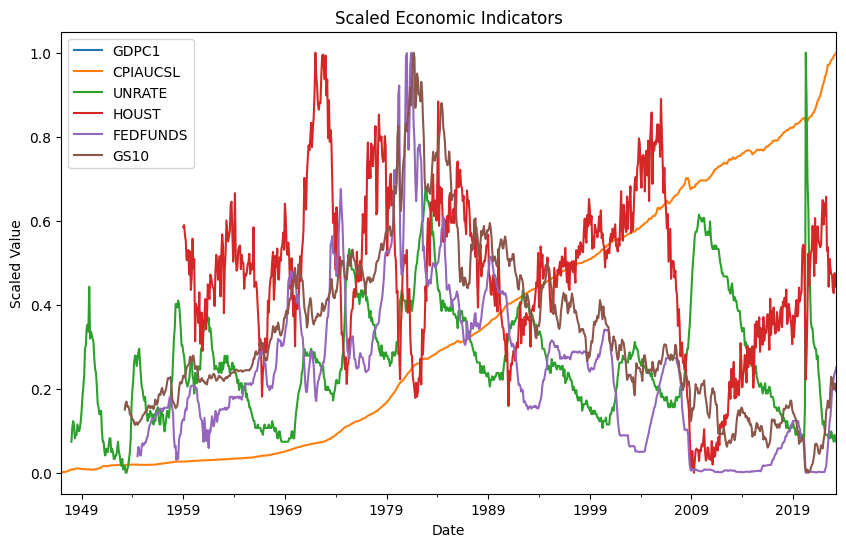

        date     GDPC1  CPIAUCSL    UNRATE     HOUST  FEDFUNDS      GS10  \
0 2022-05-01  0.989475  0.958605  0.090164  0.528274  0.037795  0.155102   
1 2022-06-01  0.989475  0.970899  0.090164  0.537202  0.060892  0.171429   
2 2022-07-01  0.989475  0.970544  0.081967  0.442956  0.085564  0.155102   
3 2022-08-01  0.989475  0.973003  0.098361  0.509425  0.119685  0.155102   
4 2022-09-01  0.989475  0.977334  0.081967  0.488591  0.131759  0.197279   

        Date  
0 2022-05-01  
1 2022-06-01  
2 2022-07-01  
3 2022-08-01  
4 2022-09-01  


In [ ]:
def economic_data(indicators):
    api_key = "7e91532102c6fdd29fc04400b31e1660"
    dfs = []

    for indicator in indicators:
        series_id = str(indicator)
        url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json"

        response = requests.get(url)
        data = response.json()

        df = pd.DataFrame(data["observations"])
        df["date"] = pd.to_datetime(df["date"])
        df["value"] = pd.to_numeric(df["value"], errors="coerce")
        df = df.dropna()
        df = df.set_index("date")
        df = df.fillna(method='ffill')  # Forward fill NaN values

        # Remove "realtime_start" and "realtime_end" columns
        df = df.drop(columns=["realtime_start", "realtime_end"])

        # Rename the column with the indicator name
        df = df.rename(columns={"value": indicator})

        dfs.append(df)

    combined_df = pd.concat(dfs, axis=1)

    # Scale the data using min-max scaling
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(combined_df)
    scaled_df = pd.DataFrame(scaled_data, columns=combined_df.columns, index=combined_df.index)

    # Plotting the scaled time series
    scaled_df.plot(figsize=(10, 6))
    plt.xlabel("Date")
    plt.ylabel("Scaled Value")
    plt.title("Scaled Economic Indicators")
    plt.legend()
    plt.show()

    return scaled_df

#indicators = [
#    'GDPC1', 'GDPDEF', 'A191RL1Q225SBEA', 'PCE', 'GPDI',  # GDP and Economic Growth
#    'CPIAUCSL', 'PPIACO', 'PCEPILFE',  # Inflation and Prices
#    'UNRATE', 'CIVPART', 'EMRATIO', 'AHETPI',  # Labor Market
#    'HOUST', 'EXHOSLUSM495S', 'MSPUS', 'CSUSHPINSA',  # Housing and Real Estate
#    'FEDFUNDS', 'GS10', 'MORTGAGE30US'  # Interest Rates
#]
indicators = [
    'GDPC1','CPIAUCSL','UNRATE','HOUST','FEDFUNDS', 'GS10']

scaled_data = economic_data(indicators)

scaled_data = scaled_data.reset_index()
scaled_data['Date'] = pd.to_datetime(scaled_data.date)
scaled_data = scaled_data[scaled_data['date'] > pd.to_datetime(start_date)].reset_index().drop('index', axis=1)
scaled_data = scaled_data.fillna(method = 'ffill').fillna(method = 'bfill')
print(scaled_data.head())

# Merging Data

In [ ]:
articles['date'] = pd.to_datetime(articles.date).dt.date

0     2023-04-30
1     2023-05-05
2     2023-05-17
3     2023-05-25
4     2023-05-05
         ...    
95    2023-05-18
96    2023-05-08
97    2023-05-05
98    2023-05-08
99    2023-04-30
Name: date, Length: 100, dtype: object

In [ ]:
def final_frame():
  articles['date'] = pd.to_datetime(pd.to_datetime(articles.date).dt.date)
  combined_news = pd.concat(y_news,articles)
  ticker = yf.Ticker(ticker_chosen)
  historical_data = ticker.history(start=start_date, end=end_date)
  historical_data = historical_data.reset_index()
  historical_data['Date'] = historical_data['Date'].dt.date
  historical_data['Date'] = pd.to_datetime(historical_data['Date'])
  historical_data['Tomorrow'] = historical_data['Close'].shift(-1)
  historical_data['target'] = (historical_data['Tomorrow'] >  historical_data['Close']).astype(int)

  merged_data = historical_data.merge(scaled_data, on='Date', how='outer')
  merged_data['Scaled_Date'] = merged_data['date'].ffill().bfill()
  merged_data = merged_data.fillna(method='ffill').fillna(method='bfill')
  combined_news['Date']= pd.to_datetime(pd.to_datetime(combined_news['date']).dt.date)
  sentiment_counts = combined_news.groupby('Date')['sentiment'].value_counts()
  sentiment_counts = sentiment_counts.unstack()
  setiment = sentiment_counts.reset_index()[['Date', 'negative','neutral','positive']].fillna(0.0)
  merged_data = merged_data.merge(setiment, on='Date', how='left')
  merged_data[['negative', 'neutral', 'positive']] = merged_data[['negative', 'neutral', 'positive']].fillna(0)
  return merged_data

In [ ]:
def final_frame():
  articles['date'] = pd.to_datetime(pd.to_datetime(articles.date).dt.date)
  y_news_valid = [item for item in y_news if isinstance(item, (pd.Series, pd.DataFrame))]
  combined_news = pd.concat(y_news_valid + [articles])
    # Rest of the code...
  ticker = yf.Ticker(ticker_chosen)
  historical_data = ticker.history(start=start_date, end=end_date)
  historical_data = historical_data.reset_index()
  historical_data['Date'] = historical_data['Date'].dt.date
  historical_data['Date'] = pd.to_datetime(historical_data['Date'])
  historical_data['Tomorrow'] = historical_data['Close'].shift(-1)
  historical_data['target'] = (historical_data['Tomorrow'] > historical_data['Close']).astype(int)

  merged_data = historical_data.merge(scaled_data, on='Date', how='outer')
  merged_data['Scaled_Date'] = merged_data['date'].ffill().bfill()
  merged_data = merged_data.fillna(method='ffill').fillna(method='bfill')
  combined_news['Date'] = pd.to_datetime(pd.to_datetime(combined_news['date']).dt.date)
  sentiment_counts = combined_news.groupby('Date')['sentiment'].value_counts()
  sentiment_counts = sentiment_counts.unstack()
  sentiment = sentiment_counts.reset_index()[['Date', 'negative', 'neutral', 'positive']].fillna(0.0)
  merged_data = merged_data.merge(sentiment, on='Date', how='left')
  merged_data[['negative', 'neutral', 'positive']] = merged_data[['negative', 'neutral', 'positive']].fillna(0)
  return merged_data


In [ ]:
x = final_frame()[['Close', 'Volume', 'GDPC1', 'CPIAUCSL','UNRATE', 'HOUST', 'FEDFUNDS', 'GS10', 'negative','neutral', 'positive']][:250]
y = final_frame()['target'][:250]
ytest = final_frame()['target'][-100:]
xtest = final_frame()[['Close', 'Volume', 'GDPC1', 'CPIAUCSL','UNRATE', 'HOUST', 'FEDFUNDS', 'GS10', 'negative','neutral', 'positive']][-100:]

# Predicting Buy/Sell

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.neighbors import KNeighborsClassifier, LabelPropagation, LabelSpreading
from sklearn.linear_model import LogisticRegression

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize the models
models = [
    BernoulliNB(),
    DecisionTreeClassifier(),
    DummyClassifier(),
    ExtraTreesClassifier(),
    GaussianNB(),
    GaussianProcessClassifier(),
    KNeighborsClassifier(),
    LabelPropagation(),
    LabelSpreading(),
    LogisticRegression(),
    BernoulliNB(),
    ExtraTreesClassifier()
]

# Iterate over the models and evaluate their performance
for model in models:
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(xtest)  # Make predictions
    
    # Evaluate the model
    accuracy = accuracy_score(ytest, y_pred)
    
    # Print the evaluation metric
    print(model.__class__.__name__)
    print("Accuracy:", accuracy)
    print()


In [ ]:
from operator import neg
import datetime
import pandas as pd
import yfinance as yf
def current_day(ticker, neg, pos, nut):
    end_date = datetime.date.today()
    ticker_name = yf.Ticker(ticker)
    historical_data = ticker_name.history(start=start_date, end=end_date)
    historical_data = historical_data.reset_index()
    latest = scaled_data.tail(1)
    latest[['Close']] = historical_data.tail(2).dropna()[['Close']].values[0]
    latest[['Volume']] = historical_data.tail(2).dropna()[['Volume']].values[0]
    latest['negative'] = neg
    latest['positive'] = pos
    latest['neutral'] = nut
    return latest

In [ ]:
def next_day_b_s(tick,neg, pos, nut):
    length_train = len(final_frame())
    length_train = round(length_train * 0.8)
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.neighbors import KNeighborsClassifier

    # Select the features and target
    x = final_frame()[['Close', 'Volume', 'GDPC1', 'CPIAUCSL', 'UNRATE', 'HOUST', 'FEDFUNDS', 'GS10', 'negative', 'neutral', 'positive']][:length_train]
    y = final_frame()['target'][:length_train]

    # Scale the input features
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)

    # Create the K-Nearest Neighbors classifier
    model = KNeighborsClassifier()

    # Train the model
    model.fit(x, y)

    # Make predictions on the test set
    new_data = current_day(tick,neg, pos, nut)[['Close', 'Volume', 'GDPC1', 'CPIAUCSL', 'UNRATE', 'HOUST', 'FEDFUNDS', 'GS10', 'negative', 'neutral', 'positive']]
    y_pred = model.predict(new_data)

    # Calculate the accuracy of the model
    if y_pred[0] == 0:
        print("Sell")
    else:
        print("Buy")
next_day_b_s(ticker_chosen,1, 1, 1)

Buy


<ipython-input-27-714c8e3fb2b9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest[['Close']] = historical_data.tail(2).dropna()[['Close']].values[0]
<ipython-input-27-714c8e3fb2b9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest[['Volume']] = historical_data.tail(2).dropna()[['Volume']].values[0]
<ipython-input-27-714c8e3fb2b9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

# Visualizations 

### Sentiment Analysis 

<ipython-input-29-baa6ec90fd18>:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  combined_news['date'] = pd.to_datetime(combined_news['date']).dt.date
<ipython-input-29-baa6ec90fd18>:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  combined_news['date'] = pd.to_datetime(combined_news['date']).dt.date
<ipython-input-29-baa6ec90fd18>:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  combined_news[

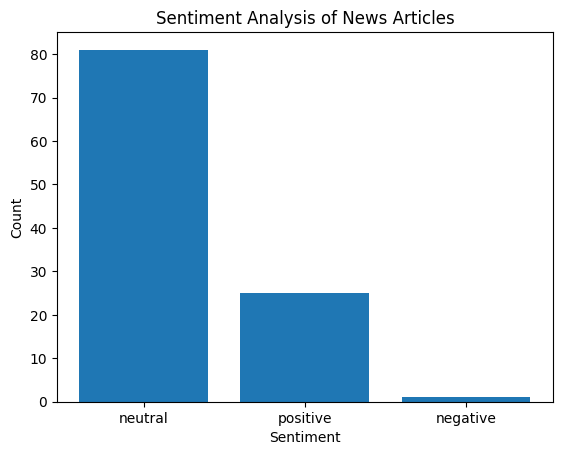

In [ ]:
# Combine the news dataframes
combined_news = pd.concat([y_news, articles])
combined_news['date'] = pd.to_datetime(combined_news['date']).dt.date
# Count the occurrences of each sentiment
sentiment_counts = combined_news['sentiment'].value_counts()

# Plot the sentiment graph
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Analysis of News Articles")
plt.show()

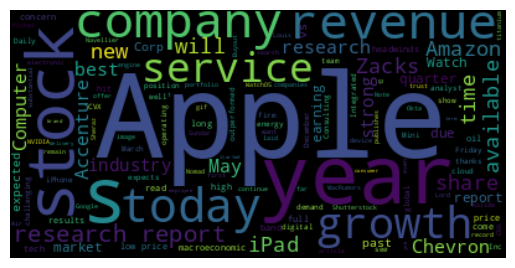

In [ ]:
def word_cloud(sentiment):
  import matplotlib.pyplot as plt
  from wordcloud import WordCloud
  tt = combined_news[combined_news['sentiment'] == str(sentiment)]
  text = ' '.join(list(tt.summary))

  # Create a WordCloud object
  wordcloud = WordCloud()
  # Generate the word cloud from text data
  wordcloud.generate(text)

  # Display the word cloud
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()
word_cloud('positive')

In [ ]:
def sentiment_time_series():
  try:
    full_sentiment = pd.concat([y_news, articles])
    full_sentiment['date'] = pd.to_datetime(full_sentiment['date'])
    full_sentiment['date'] = full_sentiment['date'].dt.date
    counted = full_sentiment.groupby(['date', 'sentiment']).size().unstack()
    counted = counted.reset_index()
    plt.figure(figsize=(10, 6))

    plt.bar(counted['date'], counted['positive'], label='Positive', alpha =.3)
  except:
    pass
  try:
    plt.bar(counted['date'], counted['negative'], label='Negative', alpha =.3)

  except:
    pass
  try:
    plt.bar(counted['date'], counted['neutral'], label='Neutral', alpha =.3)
    plt.legend()
    plt.ylabel('Count')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.title('Sentiment Count Time Series')
  except:
    pass
    plt.show()

<ipython-input-31-8d0978ee28b6>:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  full_sentiment['date'] = pd.to_datetime(full_sentiment['date'])
<ipython-input-31-8d0978ee28b6>:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  full_sentiment['date'] = pd.to_datetime(full_sentiment['date'])
<ipython-input-31-8d0978ee28b6>:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  full_sentiment['date'] = p

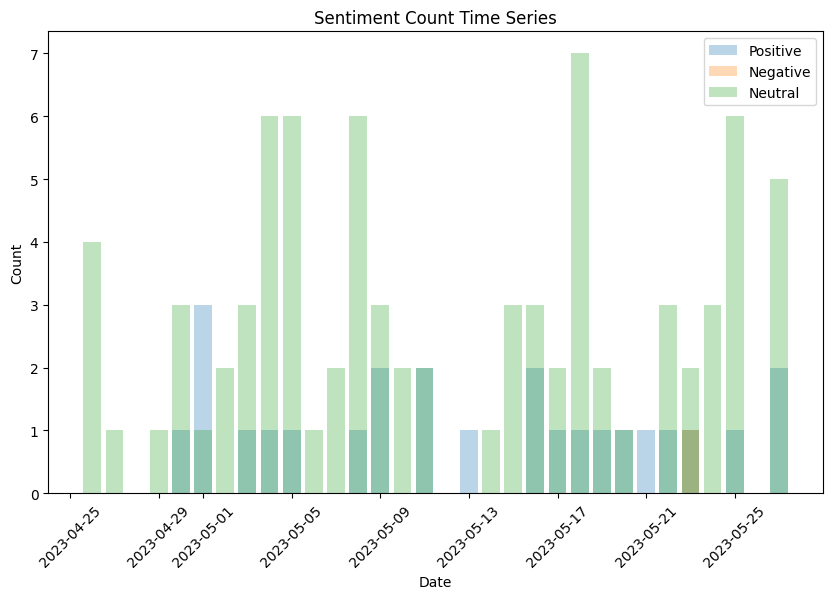

In [ ]:
sentiment_time_series()

# Stock Visuals

<ipython-input-33-8dd23634435b>:8: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  data = historical_data[i][start_date:end_date]


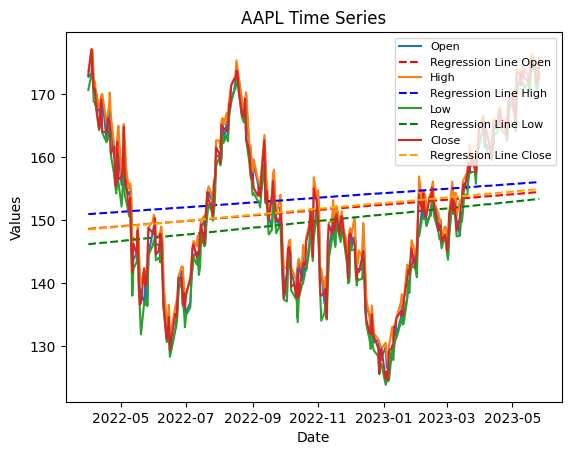

<Figure size 1600x900 with 0 Axes>

In [ ]:
def time_series(tick,start,end):
  ticker = yf.Ticker(tick)
  historical_data = ticker.history(start=start_date, end=end_date)

  colors = ['red', 'blue', 'green', 'orange']

  for i, color in zip(['Open', 'High', 'Low', 'Close'], colors):
      data = historical_data[i][start_date:end_date]
      
      x = np.arange(len(data))
      y = data.values
      slope, intercept = np.polyfit(x, y, 1)
      regression_line = slope * x + intercept
      
      plt.plot(data.index, data, label=i)
      plt.plot(data.index, regression_line, color=color, linestyle='--', label=f'Regression Line {i}')
      
  plt.xlabel("Date")
  plt.ylabel("Values")
  plt.title(f"{tick} Time Series")
  plt.legend(prop={'size': 8}, loc ="upper right")
  plt.figure(figsize=(16,9))
  plt.show()



time_series(ticker_chosen, start_date,end_date)

In [ ]:
def volume_hist(tick, start_date, end_date):
    ticker = yf.Ticker(tick)
    historical_data = ticker.history(start=start_date, end=end_date)
    days = len(historical_data)
    historical_data['Gain/Loss'] = historical_data['Close'] - historical_data['Open']
    historical_data['Gain'] = historical_data['Gain/Loss'] > 0
    volume_gain = historical_data.loc[historical_data['Gain'], 'Volume']
    volume_loss = historical_data.loc[~historical_data['Gain'], 'Volume']
    plt.hist(volume_gain, bins=20, alpha=0.5, label='Gain', color='green')
    plt.hist(volume_loss, bins=20, alpha=0.5, label='Loss', color='red')
    plt.axvline(volume_gain.mean(), color='darkgreen', linestyle='dashed', linewidth=1)
    plt.axvline(volume_loss.mean(), color='darkred', linestyle='dashed', linewidth=1)
    plt.xlabel("Volume")
    plt.ylabel("Frequency")
    plt.title(f"{tick} Volume Histogram ({days} days back)")
    plt.legend()
    plt.grid(True)
    plt.show()



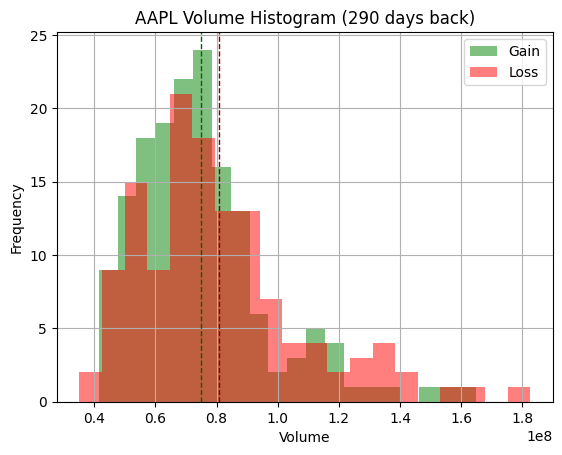

In [ ]:
volume_hist(ticker_chosen, start_date,end_date)